In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
import scipy.constants as const
from scipy.optimize import minimize_scalar as minisc
from scipy.optimize import curve_fit
import tkinter as tk
from tkinter import filedialog
from glob import glob
from natsort import natsorted

%matplotlib widget


In [2]:
def f(E, kbT):
    """The Fermi-Dirac distribution."""
    with np.errstate(over="raise", under="ignore"):
        try:
            return 1 / (np.exp(E / kbT) + 1)
        except FloatingPointError:  # use low temperature approx. if normal fails.
            return np.exp(-E / kbT)


def n(E, kbT):
    """The Bose-Einstein distribution."""
    with np.errstate(over="raise", under="ignore"):
        try:
            return 1 / (np.exp(E / kbT) - 1)
        except FloatingPointError:  # use low temperature apprµox. if normal fails.
            return np.exp(-E / kbT)

def cinduct(hw, D, kbT):
    """Mattis-Bardeen equations."""

    def integrand11(E, hw, D, kbT):
        nume = 2 * (f(E, kbT) - f(E + hw, kbT)) * np.abs(E ** 2 + D ** 2 + hw * E)
        deno = hw * ((E ** 2 - D ** 2) * ((E + hw) ** 2 - D ** 2)) ** 0.5
        return nume / deno

    def integrand12(E, hw, D, kbT):
        nume = (1 - 2 * f(E + hw, kbT)) * np.abs(E ** 2 + D ** 2 + hw * E)
        deno = hw * ((E ** 2 - D ** 2) * ((E + hw) ** 2 - D ** 2)) ** 0.5
        return nume / deno

    def integrand2(E, hw, D, kbT):
        nume = (1 - 2 * f(E + hw, kbT)) * np.abs(E ** 2 + D ** 2 + hw * E)
        deno = hw * ((D ** 2 - E ** 2) * ((E + hw) ** 2 - D ** 2)) ** 0.5
        return nume / deno

    s1 = integrate.quad(integrand11, D, (np.inf), args=(hw, D, kbT))
    if hw > 2 * D:
        s1 += integrate.quad(integrand12, (D - hw), (-D), args=(hw, D, kbT))
    s2 = integrate.quad(integrand2, (np.max((D - hw, -D))), D, args=(hw, D, kbT))
    return (s1[0], s2[0])

def S21_xa(Qi, Qc, hwread, dhw, hwres, xa):
    """Gives the complex transmittance of a capacatively coupled
    superconducting resonator (PdV PhD, eq. (3.21)), with:
    hwread -- the read out frequency
    dhw -- detuning from hwread (so actual read frequency is hwread + dhw)
    hwres -- resonator frequency"""
    Q = Qi * Qc / (Qi + Qc)
    dhw += hwread - hwres
    return (Q / Qi + complex(0.0, 2.0) * Q * (dhw / hwres + xa)) / (1 + complex(0.0, 2.0) * Q * dhw / hwres)


def S21(Qi, Qc, hwread, dhw, hwres):
    """Gives the complex transmittance of a capacatively coupled
    superconducting resonator (PdV PhD, eq. (3.21)), with:
    hwread -- the read out frequency
    dhw -- detuning from hwread (so actual read frequency is hwread + dhw)
    hwres -- resonator frequency"""
    Q = Qi * Qc / (Qi + Qc)
    dhw += hwread - hwres
    return (Q / Qi + complex(0.0, 2.0) * Q * dhw / hwres) / (1 + complex(0.0, 2.0) * Q * dhw / hwres)

In [31]:
def S21_guess(S21_data, ak, beta):
    Qi_sat = 1e16
    f_read = S21_data[0]

    #making sure units are correct:
    if any(f_read) < 1e6:
        f_read = f_read*1e9

    S21_measured = S21_data[1]
    S21_measured_trans = S21_measured  # 10**(S21_measured/10)
    # S21_min = np.min(S21_measured_trans)

    f0 = f_read[np.argmin(S21_measured)]

    # hw0 = 6.582e-4*2*np.pi*f0*1e-6 #Energy inherent in KID at fres
    # kbT0 = 86.17 * .1 #µeV, operating temperature of 100 mK
    # kbTc = 86.17 * 1 #µeV,Tc=1K
    # s10, s20 = cinduct(hw0, 1.76*kbTc, kbT0)
    # Qi_Nqp0 = 2/(ak*beta) * s20/s10

    # Qi = Qi_Nqp0 * Qi_sat / (Qi_Nqp0 + Qi_sat) 
    # Q = S21_min*Qi
    # Qc = Qi*Q/(Qi-Q)
    # xa_man = 9e-6 
    Q = 50e3
    Qc = 50e3
    Qi = 500e3
    
    def S21_fit_func(f_read, Qi, Qc, xa):
        S21_fit = 10*np.log10(np.abs(S21_xa(Qi, Qc, f_read, 0, f0, xa)))
        return S21_fit

    popt,pcov = curve_fit(S21_fit_func, f_read, S21_measured_trans, p0=[Qi,Qc, 0], bounds=([Qi/10, Qc/10, -1], [Qi*10, Qc*10, 1]))
    

    # S21_manual = S21_xa(Qi/50, Qc/50, f_read, 0, f0, xa_man)
    # print(f"Manual guess: Qi_man = {Qi/10}, Qc_man = {Qc/10}, xa_man = {xa_man}")
    S21_fit = S21_xa(popt[0], popt[1], f_read, 0, f0, popt[2])
    print(f"Fitted values: Qi_fit = {popt[0]}, Qc_fit = {popt[1]}, xa_fit = {popt[2]}")
    # print(pcov)
    # return lib.dB_scale(S21_0) + np.max(S21_measured)
    return S21_fit, popt

In [4]:
# def open_dat_file():
#     root = tk.Tk()
#     root.withdraw()  # Hide the root window
#     file_path = filedialog.askopenfilename(filetypes=[("DAT files", "*.dat")])
#     return file_path


# def read_dat_file(file_path):
#     data = np.loadtxt(file_path)
#     return data

# Example usage:
# open_dat_file()
# data = read_dat_file(file_path)
# print(data)

[4.179344 4.194687 4.256687 4.257156 4.269875 4.326969 4.342094 4.398594
 4.41325  4.468687 4.484094 4.539937 4.553187 4.61125  4.613188 4.62225
 4.679062 4.690844 4.751156 4.764188 4.819562 4.832219 4.89375  4.903875
 4.962063 4.963687 4.977719 5.027406 5.041563 5.099125 5.112312 5.16925
 5.183531 5.237594 5.251094 5.311906 5.312812 5.323437 5.382375 5.3935
 5.455781 5.468156 5.521219 5.530812 5.546469 5.593281 5.606438 5.657281
 5.667875 5.729844 5.745875 5.760937 5.771781 5.80075  5.812563 5.896063
 5.942719 5.954313 5.967844 5.983437 6.222281 6.2365   6.312938 6.326844
 6.359156 6.378531 6.3845   6.398719 6.45125  6.517938 6.542438 6.575938
 6.588063 6.609219 6.619219 6.666719 6.674625 6.714781 6.737406 6.804875
 6.807313 6.819937 6.884281 6.899938 6.943062 6.955063 7.026125 7.037656
 7.094656 7.106344 7.167406 7.173063 7.179687 7.242187 7.255969 7.310531
 7.321562 7.382094 7.394531 7.442375 7.454063 7.511312 7.517125 7.526375
 7.594781 7.610406 7.657687 7.668875 7.723094 7.732375 

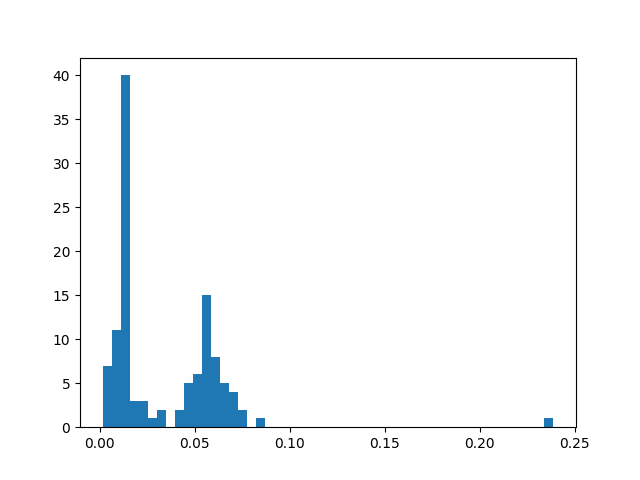

In [88]:
def open_numpy_array(skip_rows=0):
    root = tk.Tk()
    root.withdraw()  # Hide the root window

    # Open file dialog to select the directory and file name
    file_path = filedialog.askopenfilename(filetypes=[("All Files", "*.*")])
    
    if file_path:
        if file_path.split('.')[-1] == 'npy':
            arr = np.load(file_path)
            print(f"Array loaded from {file_path}")
            return arr
        elif file_path.split('.')[-1] == 'dat':
            arr = np.loadtxt(file_path, delimiter='\t', skiprows=skip_rows, dtype=float)
            return arr
    else:
        print("Open operation cancelled")
        return None

pread = 116
kid = 1
dir = r'Z:\KIDonSun\experiments\Entropy ADR\LT361w2chip7_BF_20241015\S21\Power'
files = glob(dir+'\*' + str(pread) + 'dBm*.dat')
kidlistpath = r'Z:\KIDonSun\experiments\Entropy ADR\LT361w2chip7_BF_20241015\KIDlist_121.m'
kidlist = np.loadtxt(kidlistpath)
f0s = kidlist[2:][:, 1]
ids = kidlist[2:][:, 0]
dfs = f0s[1:] - f0s[:-1]
thres = .001
too_close = dfs < thres  
too_close = np.hstack((too_close, False))
remove = too_close + np.roll(too_close, 1)

f0s = f0s[~remove]
dfs = f0s[1:] - f0s[:-1]
fig, ax = plt.subplots()
_ = ax.hist(dfs, bins=50)

In [ ]:
files = natsorted(files)
file_path = files[0]
print(files)
data = np.loadtxt(file_path, skiprows=8, delimiter='\t', dtype=float)
data[:, 1] -= (data[-1, 1]+data[0, 1])/2
# data[:, 1] = data[:, 1][::-1]
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1])
fit = S21_guess(data[:, :2].T, .96, 2)
ax.plot(data[:, 0], 10*np.log10(np.abs(fit[0])))